Overarching Goal: accurate and precise astrometry of Emakong from Keck data using aberrated PSF model.

Steps:
1. Construct aberrated airy model PSF with poppy
2. Fit PSF model to standard star frames
3. Show agreement between model PSF constrained by average frame and individual PSF frames
4. For the date(s) with associated standard star obs, fit Emakong feature with PSF model
5. For date(s) with associated standard star obs, compare results between analytic PSF model fit and standard star (data-driven) PSF fit
6. Use analytic model to fit Emakong for dates without associated standard star obs

In [1]:
from pylanetary.navigation import Nav
from pylanetary.utils import Body, convolve_with_beam

import paths
import copy
import numpy as np

from scipy.interpolate import RegularGridInterpolator
import scipy.optimize as op

from image_registration.fft_tools.shift import shift2d

from astropy.io import fits
import astropy.units as u
from astropy.modeling import models, fitting
from astroquery.jplhorizons import Horizons

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import patches

from photutils.detection import StarFinder, IRAFStarFinder
from photutils.psf import FittableImageModel, EPSFModel, PSFPhotometry, IterativePSFPhotometry, SourceGrouper
from photutils.background import LocalBackground

import poppy

In [2]:
def aberrated_keck_psf(wl, pixscale_arcsec = 0.009971, sz = 50, coeffs_in = [0.0, 0.0]):
    '''
    Make a simulated multi-hex aperture
    with spherical aberration to simulate Keck observations
    
    Parameters
    ----------
    wl : float, required
        wavelength in microns
    pixscale_arcsec : float, optional, default 0.009971
        pixel scale of detector in arcsec. default corresponds
        to NIRC2 after 2015
    sz : int, optional, default 50
        size of output PSF kernel in pixels
    coeffs_in : list, optional, default [0.0, 0.0]
        first coeff is defocus
        second coeff is spherical aberration
        both in units of n wavelengths
    
    References
    ----------
    Table 2.3 of https://wp.optics.arizona.edu/visualopticslab/wp-content/uploads/sites/52/2021/10/Zernike-Fit.pdf
    has the polynomials in same order as expected by code,
    but note that code here ignores piston so indices are off by one.
    Keck mirror specs from data from 
    Mast & Nelson 1988 https://adsabs.harvard.edu/full/1988ESOC...30..411M
    
    Notes
    -----
    for poppy.MultiHexagonAperture, the side and gap parameters 
    are both in meters. 
    '''
    pixscale_arcsec *= 2 #for some reason everything is factor of 2 different from expected
    fov_arcsec = sz*pixscale_arcsec / 2
    wl_meters = wl * 1e-6
    coeffs = np.zeros((11,))
    coeffs[3] = coeffs_in[0] * wl_meters
    coeffs[-1] = coeffs_in[1] * wl_meters
    
    scaling = 0.85
    osys = poppy.OpticalSystem()
    hex_aperture = poppy.MultiHexagonAperture(side=0.9*scaling, rings=3, gap=0.003, center=False)
    osys.add_pupil(hex_aperture)
    thinlens = poppy.ZernikeWFE(radius=5.0, coefficients=coeffs)
    osys.add_pupil(thinlens)
    osys.add_detector(pixelscale=pixscale_arcsec, fov_arcsec=fov_arcsec)
    psf_with_zernikewfe = osys.calc_psf(wavelength=wl_meters, display_intermediates=False)
    
    psf_with_zernikewfe[0].header
    return psf_with_zernikewfe[0].data
    

In [159]:
# load standard star data.
# held up because standard star still needs to be reduced
# but mozzy11 is stuck

In [3]:
# load Emakong data
date = '2022sep11'
infile = paths.data / 'keck' / date / 'reduced/stacked_nophot_lp.fits'
hdul = fits.open(infile) 
header = hdul[0].header
data = hdul[0].data
obs_time = header['DATE-OBS'] + ' ' + header['EXPSTART'][:-4]

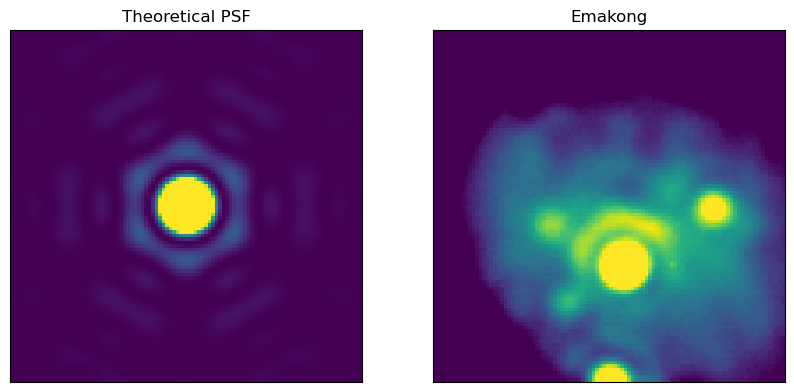

In [4]:
# make the PSF
wl = 3.776 #microns
perfect_psf = aberrated_keck_psf(wl, sz = 100, coeffs_in = [0.0, 0.0])
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10,5))
ax0.imshow(perfect_psf, origin='lower', vmin = 0, vmax=1e-3)
ax1.imshow(data[150:250,150:250], origin = 'lower', vmin = np.max(data)/3, vmax=np.max(data)/2)
ax0.set_title('Theoretical PSF')
ax1.set_title('Emakong')
for ax in [ax0, ax1]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

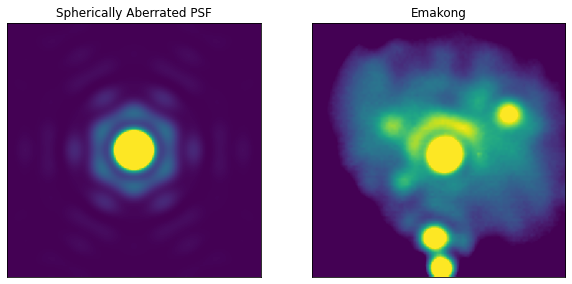

In [162]:
# add aberration
aberrated_psf = aberrated_keck_psf(wl, sz = 100, coeffs_in = [0.1, 0.0])
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10,5))
ax0.imshow(aberrated_psf, origin='lower', vmin = 0, vmax=1e-3)
ax1.imshow(data[135:235,152:252], origin = 'lower', vmin = np.max(data)/3, vmax=np.max(data)/2)
ax0.set_title('Spherically Aberrated PSF')
ax1.set_title('Emakong')
for ax in [ax0, ax1]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

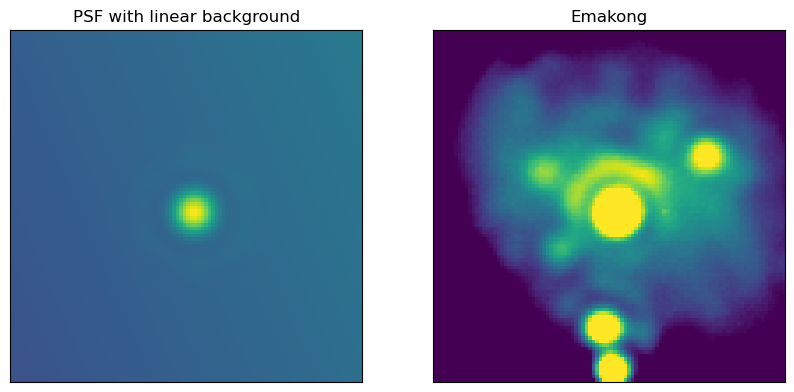

In [5]:
# attempt fit to Emakong feature plus linear background
def psf_plus_bkgd(psf, data):
    '''
    Fit PSF plus background given telescope diameter and spherical aberration coeff
    
    Parameters
    ----------
    psf : np.array, required
    data : np.array, required
    '''
    
    # low-order background
    epsf = EPSFModel(psf, oversample=1)
    p_init = epsf + models.Polynomial2D(degree=1)
    p_init.flux_0.min = 0
    fit_p = fitting.LevMarLSQFitter()
    
    # find best fit to data given that PSF shape
    y, x = np.mgrid[:data.shape[0], :data.shape[1]]
    p = fit_p(p_init, x, y, data, maxiter=1000)
    
    return p(x,y)


psf_bkgd = psf_plus_bkgd(perfect_psf[25:75, 25:75], data[135:235,152:252])
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10,5))
ax0.imshow(psf_bkgd, origin='lower', vmin = 0) #, vmax = np.max(psf_bkgd)/3)
ax1.imshow(data[135:235,152:252], origin = 'lower', vmin = np.max(data)/3, vmax=np.max(data)/2)
ax0.set_title('PSF with linear background')
ax1.set_title('Emakong')
for ax in [ax0, ax1]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## Limb darkened disk model

334.7468


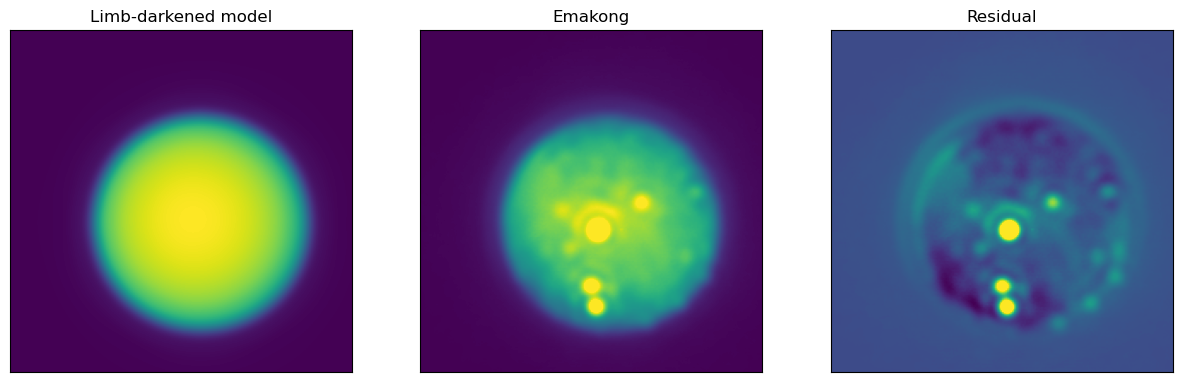

In [6]:
pixscale_arcsec = 0.009971
# calculate RMS of data and subtract slight negative background
sz = int(data.shape[0]/4)
noise_region = np.concatenate([
                data[:sz, :sz],
                data[:sz, -sz:],
                data[-sz:, :sz],
                data[-sz:, -sz:]
                ])
bkgd_mean = np.mean(noise_region)
rms = np.std(noise_region)

# navigate the image
flux = 1.1e4
a = 0.7
io = Body('Io', epoch=obs_time, location='568') #Maunakea keyword is 568
nav = Nav(data, io, pixscale_arcsec)
dx0, dy0, dxerr, dyerr = nav.colocate(
            mode='disk', 
            tb = flux, 
            a = a, 
            beam = perfect_psf,
            law='minnaert', 
            err=rms, 
            diagnostic_plot=False)
nav.xy_shift_model(dx0, dy0)
print(nav.np_ang)
ldmodel = nav.ldmodel(flux, a, beam=perfect_psf, law='minnaert')
resid = nav.data - ldmodel

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))
ax0.imshow(ldmodel[100:300, 100:300], origin='lower')
ax1.imshow(nav.data[100:300, 100:300], origin = 'lower', vmax=np.max(nav.data)/2)
ax2.imshow(resid[100:300, 100:300], origin = 'lower', vmax = np.max(resid)/3)
ax0.set_title('Limb-darkened model')
ax1.set_title('Emakong')
ax2.set_title('Residual')
for ax in [ax0, ax1, ax2]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## Strehl ratio comparisons

Here we compare 1-D cuts of theoretical PSF, aberrated PSF, and Emakong disk-subtracted "psf"

NameError: name 'aberrated_psf' is not defined

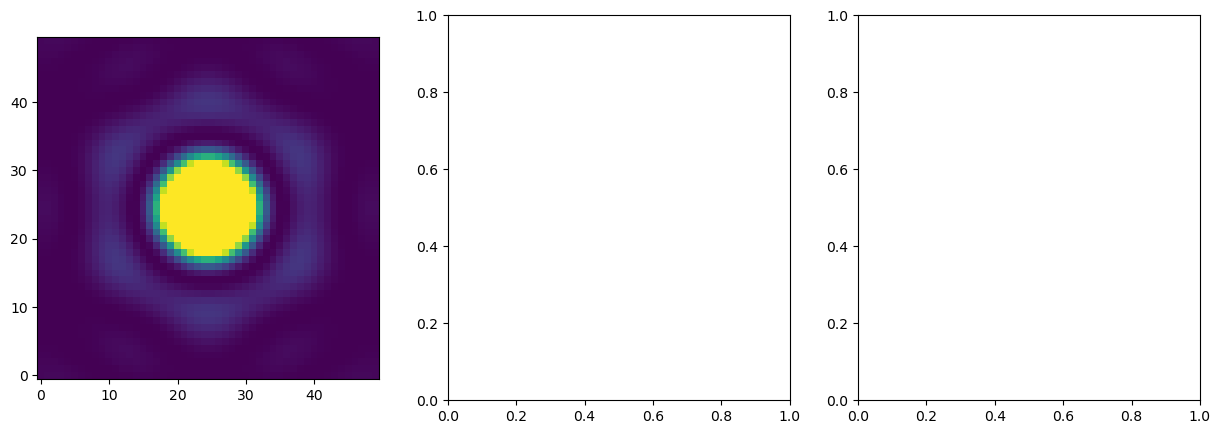

In [7]:
emakong_cutout = resid[158:208,179:229]

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))
ax0.imshow(perfect_psf[25:75,25:75], origin='lower', vmax = np.max(perfect_psf)/5)
ax1.imshow(aberrated_psf[25:75,25:75], origin='lower', vmax = np.max(aberrated_psf)/5)
ax2.imshow(emakong_cutout, origin = 'lower', vmax = np.max(emakong_cutout)/5)
ax0.set_title('Theoretical PSF')
ax1.set_title('Aberrated PSF')
ax2.set_title('Emakong')
for ax in [ax0, ax1, ax2]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

fig, (ax0, ax1) = plt.subplots(1,2, figsize = (14, 5))

labels = ['Perfect', 'Aberrated', 'Data']
for psf in [perfect_psf[25:75,25:75]/np.max(perfect_psf[25:75,25:75]), 
            aberrated_psf[25:75,25:75]/np.max(aberrated_psf[25:75,25:75]), 
            emakong_cutout/np.max(emakong_cutout)]:
    
    ax0.plot(psf[25,:])
    ax1.plot(psf[:,25])
    
ax0.set_title('Horizontal cut')
ax1.set_title('Vertical cut')
    
plt.show()

## Photutils point source fitting

Get photutils formalisms working on the residual data.

In [ ]:
def make_pointsource_model(data, psf, fwhm, thresh = 3., n=5, diagnostic_plot=True):
    '''
    Use Astropy tools to find brightest n point sources in field
    and optimize their brightness and location
    
    data : np.array, required
        2-D data
    psf : np.array, required.
        point-spread function kernel
    fwhm : float, required.
        Gaussian beam FWHM
    thresh : float, optional, default 3.
        threshold for star finder scaled to RMS noise of image
    n : int, optional, default 5
        max number of stars
    diagnostic_plot : bool, optional, default True
        show image of the stars found
    '''
    
    # find sources in field
    thresh = thresh*np.std(data)
    star_finder = IRAFStarFinder(thresh, fwhm, brightest=n, minsep_fwhm=1.)
    #sources = star_finder(data)
    #print(sources) #initial table
    
    # put them into a star model
    psf_model = EPSFModel(psf, normalize=True, norm_radius = 50)
    
    # do PSF photometry
    s = int(fwhm)
    fit_shape = (s*5+1, s*5+1)
    grouper = SourceGrouper(fwhm)
    #bkg_estimator = LocalBackground(fwhm, fwhm*5)
    psfphot = IterativePSFPhotometry(psf_model, fit_shape, finder=star_finder,
                            aperture_radius=s*5, grouper=grouper,
                           localbkg_estimator=None)
    phot = psfphot(data,)# error=error)
    #print(phot) #final table

    # plot the solution and difference
    if diagnostic_plot:
        model = psfphot.make_model_image(data.shape, fit_shape)
        resid = psfphot.make_residual_image(data, fit_shape)
        sz = data.shape[0]/2
        xx, yy = np.meshgrid(np.arange(-sz,sz), np.arange(-sz, sz))
        fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (16,6))
        ax0.imshow(data, origin = 'lower')
        ax0.set_title('Disk-subtracted data')
        #ax1.imshow(combined_model(xx, yy), origin = 'lower')
        ax1.imshow(model, origin = 'lower')
        ax1.set_title('Point source model')
        #ax2.imshow(data - combined_model(xx, yy), origin='lower')
        ax2.imshow(resid, origin='lower')
        ax2.set_title('Difference')
        plt.show()
    
    return phot

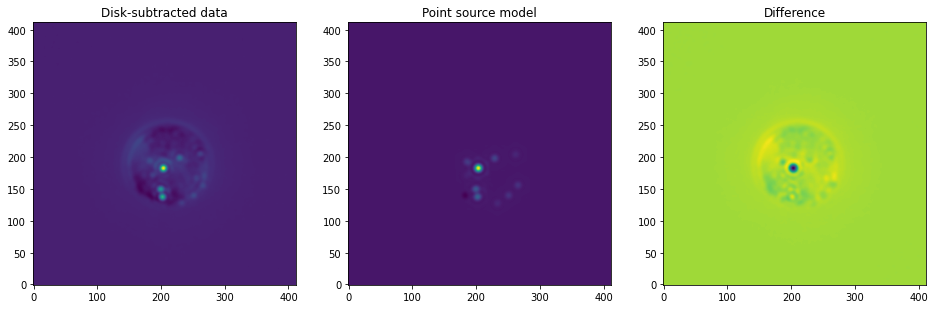

 id group_id iter_detected local_bkg       x_init             y_init            flux_init      ...      flux_err      npixfit group_size         qfit                  cfit          flags
--- -------- ------------- --------- ------------------ ------------------ ------------------- ... ------------------ ------- ---------- ------------------- ----------------------- -----
  1        1             1       0.0 203.86484429492742 182.69701614402794   4879830.589665659 ... 15503.050048491476    1681          1  0.7907217962027585  0.00022167924233927762     0
  2        2             1       0.0 202.32076772696922  137.8138997479772  1372324.9724312837 ... 19772.316733357224    1681          1  1.3309092330458585   0.0012987232777373397     0
  3        3             1       0.0 199.88339817060086 149.72394262118547   2705866.452502425 ...  23135.28681376377    1681          1  1.5678864099115313   0.0008400652587745413     0
  4        4             1       0.0   229.185734772926 198.56866

In [ ]:
pointsrc_table = make_pointsource_model(resid, perfect_psf, 8.0, thresh=3, n=10, diagnostic_plot=True)
print(pointsrc_table)

## combined disk and point source fitting

In [ ]:
combined_model = FittableImageModel(ldmodel, origin=(0,0))
psf_model = FittableImageModel(perfect_psf, normalize=True)
for line in pointsrc_table:
    volcano = copy.deepcopy(psf_model)
    volcano.flux = line['flux_fit']
    volcano.x_0 = line['x_fit']
    volcano.y_0 = line['y_fit']
    volcano.flux.min = 0.0
    combined_model += volcano
print(combined_model)

y, x = np.mgrid[:data.shape[0], :data.shape[1]]
fit_p = fitting.LevMarLSQFitter()
combined_fit = fit_p(combined_model, x, y, data, maxiter=1000)


Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11] + [12] + [13] + [14] + [15] + [16]
Components: 
    [0]: <FittableImageModel(flux=1., x_0=0., y_0=0.)>

    [1]: <FittableImageModel(flux=1702411.20507654, x_0=203.76857069, y_0=182.63781358)>

    [2]: <FittableImageModel(flux=924600.91361564, x_0=202.42764086, y_0=138.14908657)>

    [3]: <FittableImageModel(flux=786869.31387301, x_0=200.15342648, y_0=149.02411717)>

    [4]: <FittableImageModel(flux=508616.26536714, x_0=229.24865022, y_0=198.00116675)>

    [5]: <FittableImageModel(flux=163528.51415741, x_0=262.19435995, y_0=204.1547998)>

    [6]: <FittableImageModel(flux=291151.4446331, x_0=251.22096511, y_0=139.92640948)>

    [7]: <FittableImageModel(flux=1688846.77782602, x_0=203.77549924, y_0=182.6290281)>

    [8]: <FittableImageModel(flux=292599.1998638, x_0=265.85243624, y_0=155.96386039)>

    [9]: <FittableImageModel

Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11] + [12] + [13] + [14] + [15] + [16]
Components: 
    [0]: <FittableImageModel(flux=1.02483759, x_0=-0.29867188, y_0=0.64654432)>

    [1]: <FittableImageModel(flux=271360.94502905, x_0=209.72975637, y_0=193.5009357)>

    [2]: <FittableImageModel(flux=852012.76341023, x_0=202.54040438, y_0=137.64216886)>

    [3]: <FittableImageModel(flux=672000.12801719, x_0=199.93143701, y_0=149.70079317)>

    [4]: <FittableImageModel(flux=445642.04602181, x_0=229.39984228, y_0=197.96028133)>

    [5]: <FittableImageModel(flux=132965.66502154, x_0=262.73103962, y_0=204.15371695)>

    [6]: <FittableImageModel(flux=337378.97595441, x_0=251.37660152, y_0=139.71445144)>

    [7]: <FittableImageModel(flux=1626642.90895572, x_0=203.7426007, y_0=182.55584162)>

    [8]: <FittableImageModel(flux=332916.03145901, x_0=266.01163199, y_0=156.14959413)>

  

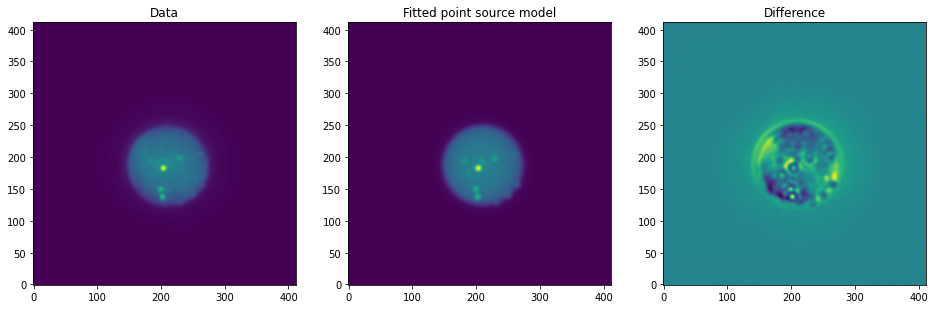

In [ ]:
print(combined_fit)
model_arr = combined_fit(x,y)
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (16,6))
ax0.imshow(data, origin = 'lower')
ax0.set_title('Data')
ax1.imshow(model_arr, origin = 'lower')
ax1.set_title('Fitted point source model')
ax2.imshow(data - model_arr, origin='lower')
ax2.set_title('Difference')
plt.show()